# Machine Learning Engineer Nanodegree

## Udacity Capston Project: Home Credit

Author: Omar Villa

Date: November 2nd 2018

## Definition

### Overview

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful

### Problem Statement

The Home Credit Default Risk competition is a supervised classification machine learning task. The objective is to use historical financial and socioeconomic data to predict whether or not an applicant or client will be able to repay the loan. This is a standard supervised classification task:

•	Supervised: The labels are included in the training data and the goal is to train a model to learn and predict the labels from the features

•	Classification: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying the loan)

The final application is expected to predict when or who are the best candidates for credit loan

### Metrics

Our evaluation metrics will be based in a ROC Curve because is what the competition specification requests but for learning purpose we will also include a Confusion Metrix to compare results.

[[1] Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

The target metric will be "TARGET" under the application_train/test datasets,
results are based on loan payed or not payed

## Analysis

### Data Exploration

application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

### Exploratory Visualization

#### Imports and data loading

In [63]:
# Libraries list
# Tools
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Data management
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# Preparation
from sklearn.preprocessing import LabelEncoder, Imputer, MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression

# Validation

In [3]:
# Load datasets
%matplotlib inline
np.random.seed(42)
pd.set_option('display.max_rows', 50)
db_datasets_list = os.listdir("D:\Datasets\HomeCredit")
application_train = pd.read_csv("D:/Datasets/HomeCredit/application_train.csv")
application_test = pd.read_csv("D:/Datasets/HomeCredit/application_test.csv")

In [4]:
# The easy way to get datasets names from destination folder.
names_list = list(os.listdir("D:/Datasets/HomeCredit/"))
names_list

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [5]:
# Determine size of datasets
# Validate Train and Test datasets have the same number of features + 1 for Train
print('Application Train Shape: {}'.format(application_train.shape))
print('Application Test Shape:  {}'.format(application_test.shape))

Application Train Shape: (307511, 122)
Application Test Shape:  (48744, 121)


#### Exploratory Data Analysis (EDA)

In [6]:
# Check TARGET feature
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

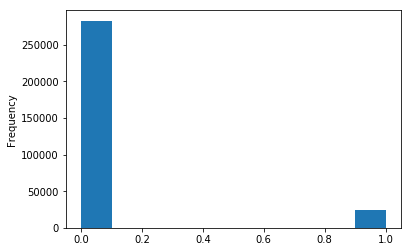

In [7]:
# Check for TARGET data distribution
#application_train['TARGET'].astype(int).plot.hist()
target_feat = application_train['TARGET'].astype(int)
target_feat.plot.hist()

In [8]:
# Check for missing data in all columns or features
def check_missing_data(dataset):
    '''
    Description: Count NaN values in dataset add them to a total variable and
        calculate the percent of missing data per columns and merge total and
        percent in a single table.
    Receives: 
        dataset - Pandas dataframe
    Returns:
        missing_data - Table with total and missing data percentage per column
    '''
    total = dataset.isnull().sum().sort_values(ascending = False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()*100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

app_train_missing_data = check_missing_data(application_train)

In [9]:
# Top 20 features with more than 60% of missing data
app_train_missing_data.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [10]:
# Show dataset statistics
def show_dataset_meta(dataset):
    '''
    Description: Display dataset metadata
    Receives:
        dataset - Pandas dataframe
    Returns:
        True - No use for it.
    '''
    print('dataset size: {}'.format(dataset.shape))
    display(dataset.describe())
    dataset.isnull().sum().sort_values(ascending=True)   
    return True

show_dataset_meta(application_train)

dataset size: (307511, 122)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


True

In [11]:
# Convert DAYS_BIRTH and DAYS_EMPLOYED features negative values to abs values
#application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
#application_train['DAYS_EMPLOYED'] = abs(application_train['DAYS_EMPLOYED'])
#application_train[['DAYS_EMPLOYED', 'DAYS_BIRTH']].head(10)

In [12]:
# Features functions to present missing data
def get_columns_with_missing_data(dataset_missing):
    '''
    Description: Use the dataset_missing data dataframe and for those columns
        with more than 60% of missing data we append the name of the columns
        in to a list.
    Receives:
        dataset_missing - Table with percentage of missing data
    Returns:
        empty_cols - List with columns with more than 60% of missing data
    '''
    empty_cols=[]
    [empty_cols.append(index) for item, index in zip(dataset_missing['Percent'], dataset_missing.index) if item > 60]
    return empty_cols

def drop_dataset_columns(dataset, to_drop_cols_list):
    '''
    Description: Drops columns with more than 60% of missing data
    Receives:
        dataset - Pandas dataset
        to_drop_cols_list - List of columns to drop from dataset
    Returns:
        True: No use for it.
    '''
    dataset.drop(to_drop_cols_list, axis=1, inplace=True)
    return True

def generate_heatmap(dataset):
    '''
    Description: Print a True/False heatmap based on missing and not missing
        Blue for not missing and Red for NaN values.
    Receives:
        dataset - Pandas dataset
    Returns:
        True: No use for it
    '''
    dims = (30, 6)
    fig, ax = pyplot.subplots(figsize=dims)
    sns.heatmap(dataset.isnull(), 
                cbar=True, 
                cmap='coolwarm',
                ax=ax)
    plt.xlabel('Features', fontsize = 22);
    plt.ylabel('Values', fontsize = 22);
    plt.title('Heatmap of empty values', fontsize = 26)
    return True

In [13]:
#app_train_cols_to_drop = get_columns_with_missing_data(app_train_missing_data)

In [14]:
#app_train_cols_to_drop

In [15]:
#drop_dataset_columns(application_train, app_train_cols_to_drop)

#### Missing data visualization
Create a heatmap of missing data to visualize in single picture 
the quality of the dataset

In [16]:
# Initial heatmap of Application_train dataset
#generate_heatmap(application_train)

#### Fill empty data

We will fill all the empty or NaN values with the mean of each feature or column, this technique will help us to expand the quality of the data.

In [17]:
# Fill missing data with the mean of the corresponding column.
def fill_missing_with_mean_val(dataset):
    '''
    Description: Fill Numeric columns with missing data or NaN with the mean 
        of the corresponding column.
    Receives: 
        dataset - Pandas dataset
    Returns:
        [dataset_num, dataset_obj] - A list of columns separated by Numeric and
        Object types.
    '''
    dataset_num = dataset.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.fillna(x.mean()),axis=1)
    dataset_obj = dataset.select_dtypes(include=['object'])
    return [dataset_num, dataset_obj]

dataset_list = fill_missing_with_mean_val(application_train)

Show heatmap of data after features mean re-fill

In [18]:
#Concat dataset_list in to a single dataframe and generate heatmap after filling empty data
app_train_full = pd.concat(dataset_list, axis=1)
#generate_heatmap(app_train_full)

We will do the same changes to test data in order to match the training set.

In [19]:
# Fill missing data with the mean of each feature.
dataset_list = fill_missing_with_mean_val(application_test)
app_test_full = pd.concat(dataset_list, axis=1)

In [20]:
# Generate heatmap after filling of features with empty values
#generate_heatmap(app_test_full)

#### One-hot encoding for qualitative data 

First will get generate dummy features for all those qualitative values in all object columns this for Train and Test data.

[[2] How to use One-Hot Encoding](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)

[[3] Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)

In [21]:
# Features One-hot encoding
app_train_full = pd.get_dummies(app_train_full)
app_test_full = pd.get_dummies(app_test_full)

In [22]:
# Check features differences between trai and test datasets after One-hot enc.
print("Application Train shape: {}".format(app_train_full.shape))
print("Application Test  shape: {}".format(app_test_full.shape))

Application Train shape: (307511, 246)
Application Test  shape: (48744, 242)


In [23]:
# app_test_full heatmap after all data is being fill up and one-hot encoded.
#generate_heatmap(app_test_full)

True

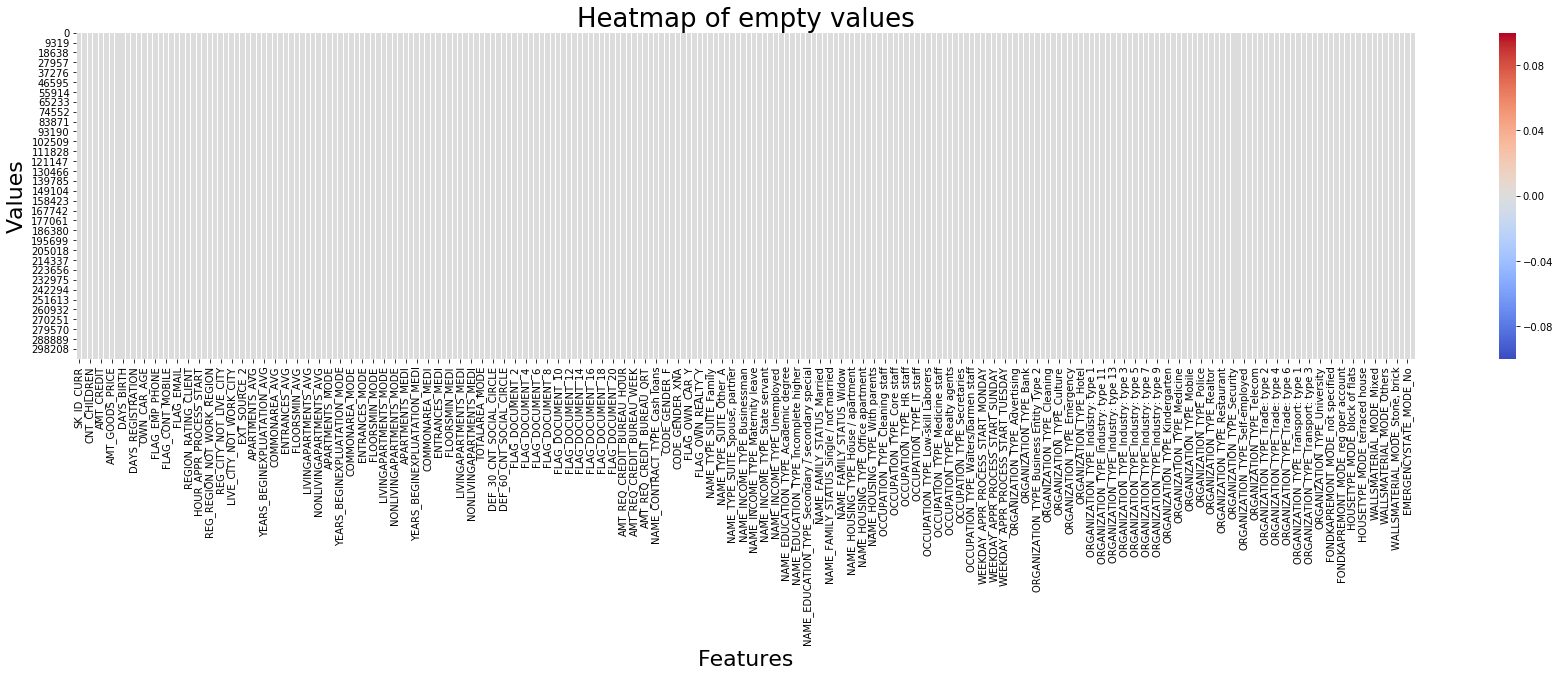

In [24]:
# app_train_full heatmap after all data is being fill up and one-hot encoded
generate_heatmap(app_train_full)

In [25]:
# Align Training and Testing data
app_train_labels = app_train_full['TARGET']
app_train_full, app_test_full = app_train_full.align(app_test_full, join = 'inner', axis=1)

In [26]:
# Check features differences between trai and test datasets after One-hot enc.
print("Application Train shape: {}".format(app_train_full.shape))
print("Application Test  shape: {}".format(app_test_full.shape))

Application Train shape: (307511, 242)
Application Test  shape: (48744, 242)


In [27]:
# Add TARGET feature back to train dataset
app_train_full['TARGET'] = app_train_labels

In [28]:
# Check features differences between train and test datasets after One-hot enc.
print("Application Train shape: {}".format(app_train_full.shape))
print("Application Test  shape: {}".format(app_test_full.shape))

Application Train shape: (307511, 243)
Application Test  shape: (48744, 242)


#### Find Anomalies

Look for anomalies among the most important features

In [29]:
# Convert DAYS_BIRTH to years and show statistics values
(app_train_full['DAYS_BIRTH'] / - 365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [30]:
# show statistics values of DAYS_EMPLOYED and find anomalies
app_train_full['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

##### Visualize anomolous data

We will show charts of what we think are the most important features and find anomalies that we can fix

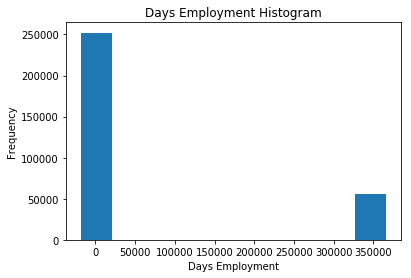

In [31]:
# Plot DAYS_EMPLOYED histogram
app_train_full['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

We can see that we have a max value totally outside of the chart

In [32]:
# Get default loans percentage based on anomalies
anom = app_train_full[app_train_full['DAYS_EMPLOYED'] == 365243]
non_anom = app_train_full[app_train_full['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [33]:
# Create an anomalous flag column to preserve anomolous data
def detect_anomalies(dataset):
    dataset['DAYS_EMPLOYED_ANOM'] = dataset["DAYS_EMPLOYED"] == 365243
    dataset["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
    return dataset

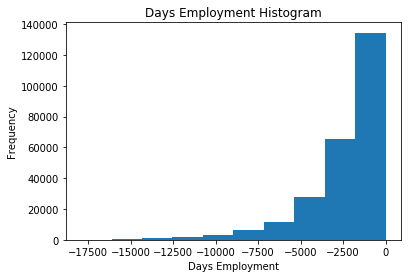

In [34]:
# Plot DAYS_EMPLOYED anomalies
app_train_full = detect_anomalies(app_train_full)
app_train_full['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [35]:
# Sync Train with Test features
app_test_full = detect_anomalies(app_test_full)

print('There are {} anomalies in the test data out of {} entries'.format(app_test_full["DAYS_EMPLOYED_ANOM"].sum(), len(app_test_full)))

There are 9274 anomalies in the test data out of 48744 entries


#### Correletations

Finding correlation between all features vs TARGET feature

In [36]:
# Get TARGET feature correletions and sort values
app_train_corr = app_train_full.corr()['TARGET'].sort_values()

In [37]:
# Display Correletions
print('Most Positive Correlations:\n', app_train_corr.tail(15))
print('\nMost Negative Correlations:\n', app_train_corr.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055190
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [38]:
# Find correlation on features with negative values.
def find_corr_abs_vals(dataset, feature):
    dataset[feature] = abs(dataset[feature])
    return dataset[feature].corr(dataset['TARGET'])

In [39]:
find_corr_abs_vals(app_train_full, 'DAYS_BIRTH')

-0.07823930830982712

In [40]:
find_corr_abs_vals(app_train_full, 'DAYS_EMPLOYED')

-0.07495845742543902

In [41]:
find_corr_abs_vals(app_train_full, 'REGION_RATING_CLIENT_W_CITY')

0.060892667564823706

In [42]:
# Function to create a histogram of a feature in years
def feature_histogram(dataset, feature, title, xlabel, ylabel):
    plt.style.use('ggplot')

    plt.hist(dataset[feature]/365, edgecolor='k', bins=25)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

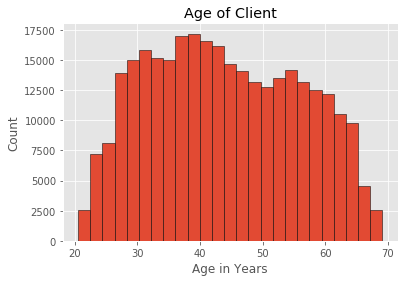

In [43]:
# Create Age of client histogram
feature_histogram(app_train_full,
                  'DAYS_BIRTH',
                  'Age of Client',
                  'Age in Years',
                  'Count')

Text(0.5,1,'Distribution of Ages')

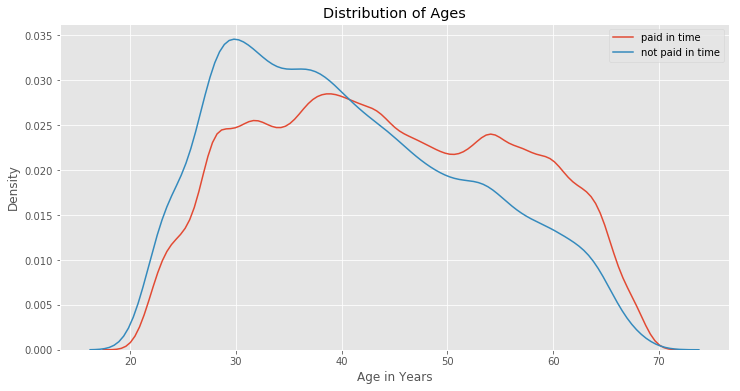

In [44]:
# Show reletionship between DAYS_OF_BIRTH and TARGET paid in time

plt.figure(figsize=(12,6))
sns.kdeplot(app_train_full.loc[app_train_full['TARGET'] == 0, 'DAYS_BIRTH']/365,
           label = 'paid in time')
sns.kdeplot(app_train_full.loc[app_train_full['TARGET'] == 1, 'DAYS_BIRTH']/365,
           label = 'not paid in time')
plt.xlabel('Age in Years')
plt.ylabel('Density')
plt.title('Distribution of Ages')

The "Not paid in time" curve shows that customers younger than 30 yeards tend to miss their paints by a 10% more.

In [45]:
# Generate Age brackets by 5 years each to see what is the failure to repay rate
age_train_bracket = app_train_full[['TARGET', 'DAYS_BIRTH']]
age_train_bracket['YEARS_BIRTH'] = age_train_bracket['DAYS_BIRTH'] / 365
age_train_bracket['YEARS_BINNED'] = pd.cut(age_train_bracket['YEARS_BIRTH'], 
                                           bins= np.linspace(20,70,num = 11))
age_train_bracket.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1.0,9461.0,25.920548,"(25.0, 30.0]"
1,0.0,16765.0,45.931507,"(45.0, 50.0]"
2,0.0,19046.0,52.180822,"(50.0, 55.0]"
3,0.0,19005.0,52.068493,"(50.0, 55.0]"
4,0.0,19932.0,54.608219,"(50.0, 55.0]"
5,0.0,16941.0,46.413699,"(45.0, 50.0]"
6,0.0,13778.0,37.747945,"(35.0, 40.0]"
7,0.0,18850.0,51.643836,"(50.0, 55.0]"
8,0.0,20099.0,55.065753,"(55.0, 60.0]"
9,0.0,14469.0,39.641096,"(35.0, 40.0]"


In [46]:
# Group by the bin and calculate averages
age_groups = age_train_bracket.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


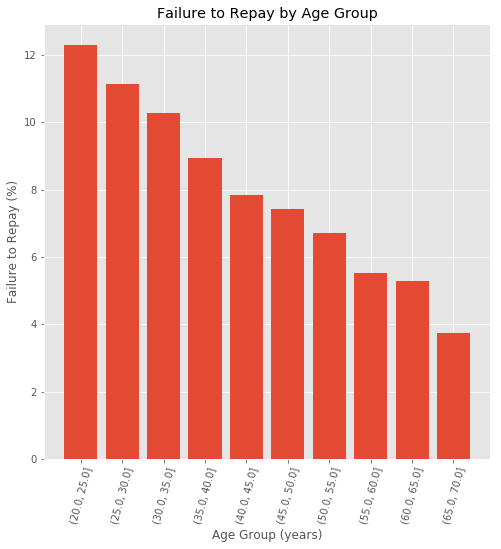

In [47]:
# Graph the age bins and the average of the target as a bar plot
plt.figure(figsize = (8, 8))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); 
plt.xlabel('Age Group (years)'); 
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Tendency is very clear that young applicants fail to repay their loans and after the 35 years hold bracket we can see how the failure of loan repayments start to drop, this information can be use by Home Credit to better evaluate future applicants.

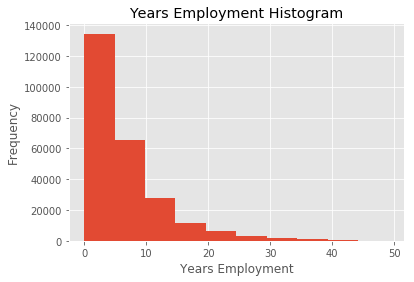

In [48]:
# Plot DAYS_EMPLOYED histogram by Years
(app_train_full['DAYS_EMPLOYED']/365).plot.hist(title = 'Years Employment Histogram', bins=10);
plt.xlabel('Years Employment');

Text(0.5,1,'Distribution of Years Employed')

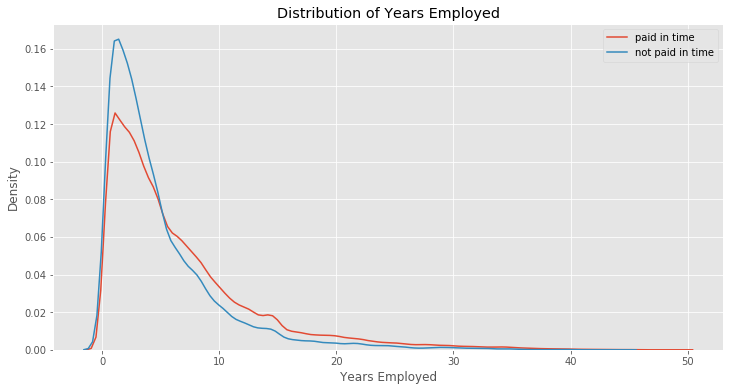

In [49]:
# Show reletionship between DAYS_EMPLOYED and TARGET paid in time

plt.figure(figsize=(12,6))
sns.kdeplot(app_train_full.loc[app_train_full['TARGET'] == 0, 
                               'DAYS_EMPLOYED']/365,
           label = 'paid in time')
sns.kdeplot(app_train_full.loc[app_train_full['TARGET'] == 1, 
                               'DAYS_EMPLOYED']/365,
           label = 'not paid in time')
plt.xlabel('Years Employed')
plt.ylabel('Density')
plt.title('Distribution of Years Employed')

Distribution tells us that the high risk the business takes when lends to applicants with 0-8 years of employment and stabilizes after 10 years of employment this in combination with the Age of the applicant we can say that those who have more than 35 years with 10 or more years of employment are good candidates for the loan

### Algorithms and Techniques

We will use logistic regression as our first treshold because our target feature is a binary feature and works really well with this type of data. We will also use KNN algorithm as our second benchmark just to compare which of both algorithms presents the best results.

    * Logistic Regresion training steps
        * Use training dataset
        * Drop TARGET feature from training dataset and save TARGET feature
        * Copy the dataset 
        * Fit and transform data
        * Specify regularization parameter
        * Make predictions
        * Save results in a submission file.
        
    * KNN training steps [4]
        * Handle Data (already done in exploratory section)
        * Similarity: Calculate the distance between two data instances.
        * Neighbors: Locate k most similar data instances.
        * Response: Generate a response from a set of data instances.
        * Accuracy: Summarize the accuracy of predictions.
        * Main: Tie it all together.

During training datasets are loaded in to RAM and processed with a CPU, this because we are using Scikit-Learn and it doesnt support GPU processing.

[[4] Implement KNN](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)

In [52]:
# Not is use
def fit_transform(dataset):
    # Drop TARGET feature from full training dataset
    train = app_train_full.drop('TARGET', axis=1)
    # Save features names in a list
    features_names = list(train.columns)
    # Copy of the testing data to preserve original data
    test = app_test_full.copy()
    # Create an object to Scale all features in a 0 to 1 range
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range = (0,1))
    # Impute missing data
    from sklearn.preprocessing import Imputer
    imputer_obj = Imputer()
    # Fit training data
    imputer_obj.fit(train)
    # Transform train and test data
    train = imputer_obj.transform(train)
    test = imputer_obj.transform(test)
    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    print('Training data shape: ', train.shape)
    print('Testing data shape: ', test.shape)

In [64]:
# fill missing values with mean column values
train = app_train_full.drop('TARGET', axis=1)
test = app_test_full.copy()

train_values = train.values
test_values = test.values

imputer = Imputer()

# Impute data
train_transformed_values = imputer.fit_transform(train_values)
test_transformed_values = imputer.fit_transform(test_values)

# Scale values
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train_transformed_values)
train_scaled = scaler.transform(train_transformed_values)
test_scaled = scaler.transform(test_transformed_values)

print('Training data shape: ', train_scaled.shape)
print('Testing  data shape: ', test_scaled.shape)

Training data shape:  (307511, 243)
Testing  data shape:  (48744, 243)


We have filled, fitted and transform our data so is ready for Machine Learning algorithm analysis.

[[5] Understanding transform functions](http://pbpython.com/pandas_transform.html)

[[6] How to handle missing data](https://machinelearningmastery.com/handle-missing-data-python/)

#### Grid Search for C value
Before we go ahead and use a Logistic Regresion model, we will like to know what are the best parameters for our data mainly the regularization strength (C) and posibly find the best penalty (L1 or L2) which in most of the cases is always L2  but we will like to be 100% positive on this.

[[6] Grid Search](https://www.kaggle.com/enespolat/grid-search-with-logistic-regression)

In [65]:
# Grid search cross validation
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, grid,cv=10)
logreg_cv.fit(train_scaled,app_train_labels)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :", logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l1'}
accuracy : 0.9192711805431351


### Benchmark Model 
As this is a kaggle compettion a benchmark model would be SK_ID_CURR in the test set, who must predict a probability for the TARGET variable. The submission will be evaluated on area under the ROC curve between the predicted probability and the observed target. 
We will use Logistic Regression and KNN algorithms as our benchmark model because of their simplicity to create a baseline score.

## Methodology

### Data Preprocessing

The preprocessing consists of the following steps:
    1. Usually data is split in train test, but this was already provided by client.
    2. Navigate the data describing and using charts to understand data distribution and catch anomalies.
    3. Clean up data of Blanks or NaN's.
    4. Scale up the data to help with features with big differences in values, data will be fit and transform before this.

### Implementation

All stages where done in a Jupyter Notebok (titled "Capstone Home Credit Project") and further divided into the following steps:

The initial implementation took very long to finish because we searched at the same time for the best loggistic regression parameters, also after initial loggistic regression was completed we notice that we miss to scale our data and went back and restarted the fitting and training process, noticing that our first run was 95% accurate. In our second execution, our model also took more than 1 hour to complete but with scaling now in place accuracy changed to 91.92% 

Implementation steps:
    1. Load datasets
    2. Determine sizes of datasets and isolate target feature
    3. Do a quick check for missing data
    4. Find out how data is distributed to later capture inconsistencies
    5. Visialize data through a heatmap to see how bad is the data in what missing data means.
    6. Fill empty numeric data and isolate non-numberic data
    7. One-hot encode qualitative data and align with test data
    8. Find anomalies
    9. Find correlations with target feature
    10. Impute and Scale data
    10. Grid search regularization strenght and best penalty
    11. Implement Loggistic Regression and check for accuracy.

Fig. 1 shows how loggistic regression will help us with our target prediction because target values are all 0's or 1's
![Logistic Regression](LR.png "Logistic Regression")
[Source](https://qph.fs.quoracdn.net/main-qimg-914b29e777e78b44b67246b66a4d6d71)


#### Refinement

As mentioned in the Benchmark section we will look to improve our model using KNN algorithm which so far it will be hard to improve because Loggistic Regression already give us a 91.92% accuracy rate

In [67]:
from sklearn.metrics import confusion_matrix

train_pred = logreg_cv.predict(train_scaled)
cmx = confusion_matrix(train_scaled, app_train_labels)  

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [71]:
app_test_full.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48744.000000,4.874400e+04,48744.000000,48744.000000,39470.000000,48744.000000,...,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29421.765523,4.626188e+05,0.021226,-16068.084605,-2476.738941,-4967.652716,...,0.004185,0.029296,0.007242,0.005929,0.005826,0.231187,0.214057,0.016289,0.537071,0.007303
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16017.123095,3.367102e+05,0.014428,4325.900393,2307.963913,3552.612035,...,0.064558,0.168636,0.084792,0.076772,0.076109,0.421596,0.410171,0.126587,0.498629,0.085149
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17959.500000,2.250000e+05,0.010006,-19637.000000,-3328.750000,-7459.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26194.500000,3.960000e+05,0.018850,-15785.000000,-1765.000000,-4490.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-861.000000,-1901.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,-1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
